# Transformer

## Notes on Attention is all you need

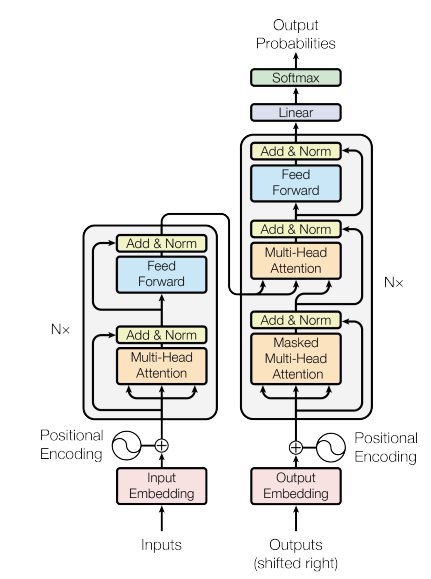

### The encoder

Each input word is converted to an embedding vector using WordToVec network.  The dimension of the imbedding is called $d_{\text model} = 512$

The encoder consists of positional encoding followed by $6$ stacks of the encoding block.  Each encoding block itself
consists of a multi-head attention block followed by a feed forward linear block.  In addition around each block is a skip
connection.

The input has length $l$. This is actually the max input length.  Shorter inputs are padded to length $l$.

#### Attention Block

For each embedded input word, the network generates a query, key and value vectors by multiplying the embedding vector by some learned weight matrices $Q$, $K$ and $V$.  Query, key and value vectors have dimensions $d_q$, $d_k$ and $d_v$, but here they all in fact have the same dimension of $64$. (check) 

It should be noted that the query, key and value vectors can be computed simultaniously for all the inputs and we can just query, key and value matrices instead.

To compute a score vector for a query it is dot producted against the key vectors.  This vector is in turn normalized by $\frac{1}{\sqrt{d_k}}$. After that we softmax and finally multiply the result by the value vector.  Of course this is more compactly done in the matrix form simultaniously for all inputs:

$$\text{Attention}\left(\textbf{Q}, \textbf{K}, \textbf{V} \right) = \text{Softmax}\left(\frac{\textbf{Q}\textbf{K}^T}{\sqrt{d_k}}\right)\textbf{V}$$ 

#### Some dimension analysis


* To map the embeddings to the queries, keys and values, we used matrices $Q$, $K$ and $V$. We are mapping from $\mathbb{R}^{d_\text{model}}$ to $\mathbb{R}^{d_v}$. So these matrices have dimensions $d_{\text{model}} \times d_v$


* The matrices $\mathbf{Q}$, $\mathbf{K}$, $\mathbf{V}$ are all input dim $l$ by $d_v$


* $\textbf{Q}\textbf{K}^T$ is $l \times l$


* Attention is then $l \times d_v$


We have $h=6$ of these attentions from all the $h$ heads.  We concatinate them together as matrix $\textbf{A}$ that has dimension $l\times (h d_v)$. Then we multiply $\textbf{A}$ by a matrix $\textbf{W}$ which has dimension $h d_v \times d_{\text{model}}$ We call the resulting matrix $\textbf{Z}$.  Now $\textbf{Z}$ has the dimension $l \times d_{\text{model}}$. Note that the skip connection combines the input with $\textbf{Z}$ so dimensionwise this makes sense.

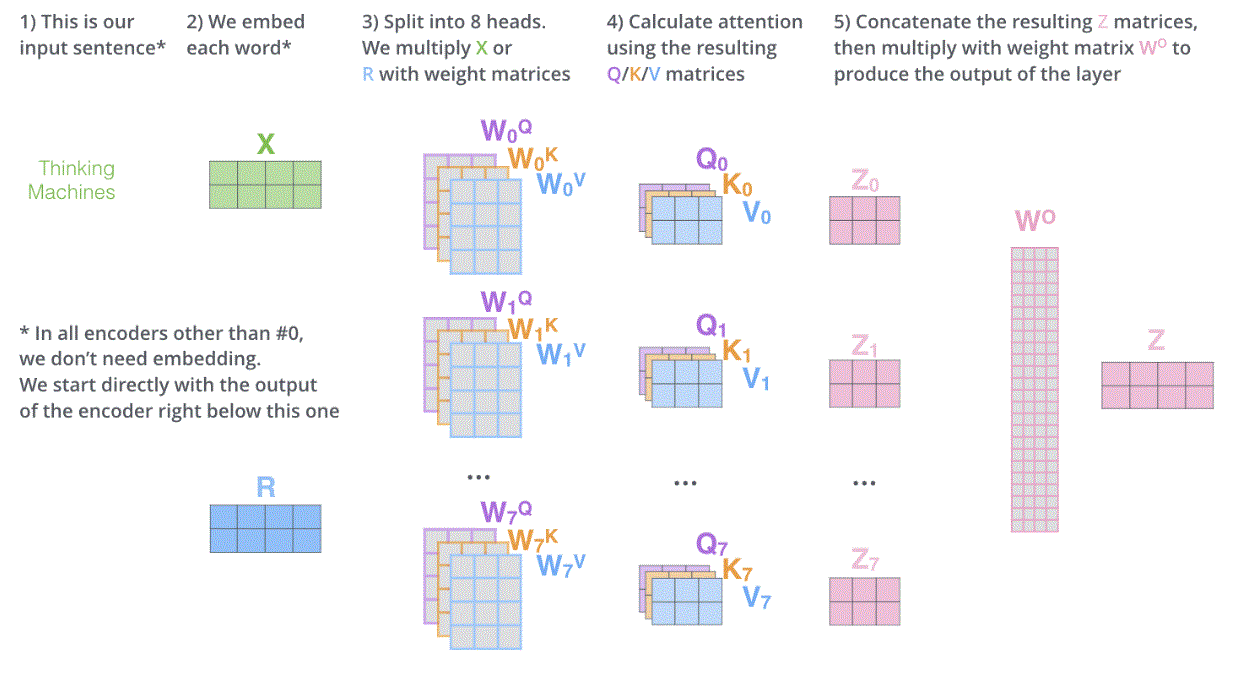

#### Multi-head

Each attention block actually consists of $h$ independent attention layers running in parallel.  These layers have their own learned weight matrices $Q$, $K$ and $V$.  The result of these layers are concatenated and projected. Google team used $h=8$.  The advantage of using multiple different embeddings was to use multiple representations to simultaneously attend different input locations.

### Decoder

The decoder is similar to the encoder: The first layer is a positional encoding over the input into the decoder. This block is not repeated. The input into the positional encoder is all the words decoded up to previous time step.  The next component is a stack of N = 6 identical layers. These are similar to the encoder. There is a multi-head attention layer over the input of the decoder followed by a multi-head attention over the input from the encoder.

The self attention layers in the decoder operate in a slightly different way than the one in the encoder:

In the decoder, the self-attention layer is only allowed to attend to earlier positions in the output sequence. This is done by masking future positions (setting them to -inf) before the softmax step in the self-attention calculation.

The “Encoder-Decoder Attention” layer works just like multiheaded self-attention, except it creates its Queries matrix from the layer below it, and takes the Keys and Values matrix from the output of the encoder stack.

The last sub-layer is again a feed forward followed by normalization.  As in the encoder there are skip connections around every sub-layer connecting to the add + normalize layer.  The self-attention sub-layer in the decoder is modified so as to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i. 


Finally there is a softmax liner layer and a softmax to get an embedding vector for probability of the next word.  The decoder is run repeatedly until it predicts end of sentence token.

### Positional Encoding

To give the network information about word order, the positional encoding is added in after the word embeddings.  This consists of funtions of following form:

$$\text{PE}(\text{pos}, 2i) = \sin(\text{pos}/ 10000^{2i/d_{\text{model}}})$$
$$\text{PE}(\text{pos}, 2i+1) = \cos(\text{pos}/ 10000^{2i/d_{\text{model}}})$$

Here pos is the location of the word in the input and $i$ is the dimension.

where pos is the position (word location) and i is the dimension (along the embedding). That is, each dimension of the positional encoding corresponds to a sinusoid. The wavelengths form a geometric progression from 2π to 10000 · 2π. We
chose this function because we hypothesized it would allow the model to easily learn to attend by
relative positions, since for any fixed offset k, P Epos+k can be represented as a linear function of
P Epos.

They chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.
